<a href="https://colab.research.google.com/github/jumpingsphinx/ESE2030/blob/main/ESE2030HW9_Pt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully loaded textbook: 593461 characters

Preview of textbook content:
--------------------------------------------------
LINEAR ALGEBRA : ESSENCE & FORM
ROBERT GHRIST
(c) 2024 ROBERT GHRIST
PUBLISHED BY AGENBYTE PRESS

# Incipit

Mathematics is the language of modern engineering, and linear algebra its American dialect -- inelegant, practical, ubiquitous. This text aims to prepare engineering students for the mathematical aspects of artificial intelligence, data science, dynamical systems, machine learning, and other fields whose advances depend critically on linear algebraic methods.

The reader arrives here havi...
--------------------------------------------------

Processing textbook in manageable chunks...
Created 119 chunks from the textbook.

Preprocessing text...
Full processed text length: 429443 characters

Sample of

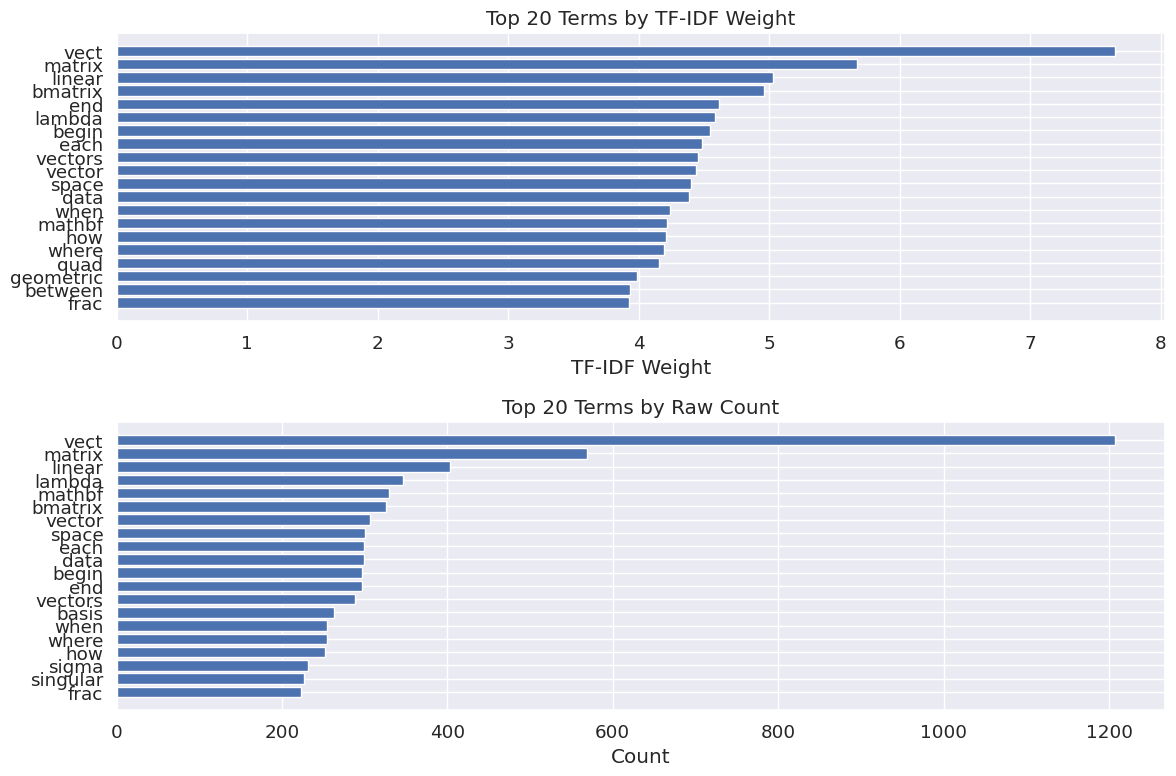

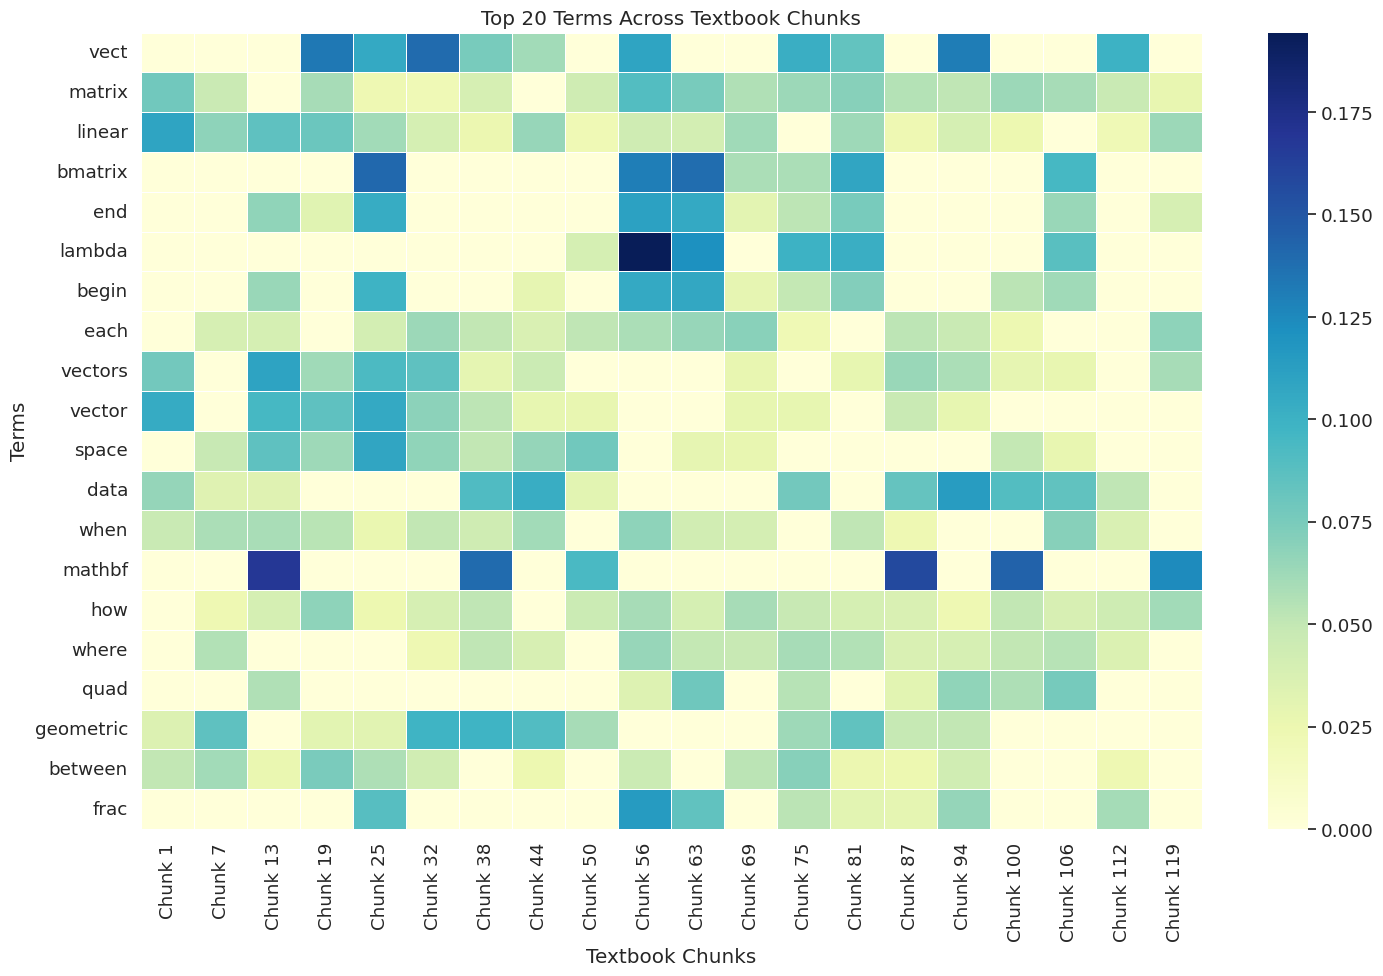


Computing word frequencies for the entire textbook...
Total unique words after preprocessing: 4853

Top 30 words in the entire textbook:
vect: 1205
matrix: 569
from: 470
through: 439
linear: 403
lambda: 346
structure: 332
mathbf: 330
bmatrix: 328
vector: 307
space: 300
data: 299
each: 299
begin: 297
end: 297
vectors: 290
basis: 264
when: 256
where: 254
how: 252
sigma: 232
singular: 227
frac: 223
between: 221
geometric: 217
orthogonal: 214
quad: 214
form: 204
while: 203
into: 198


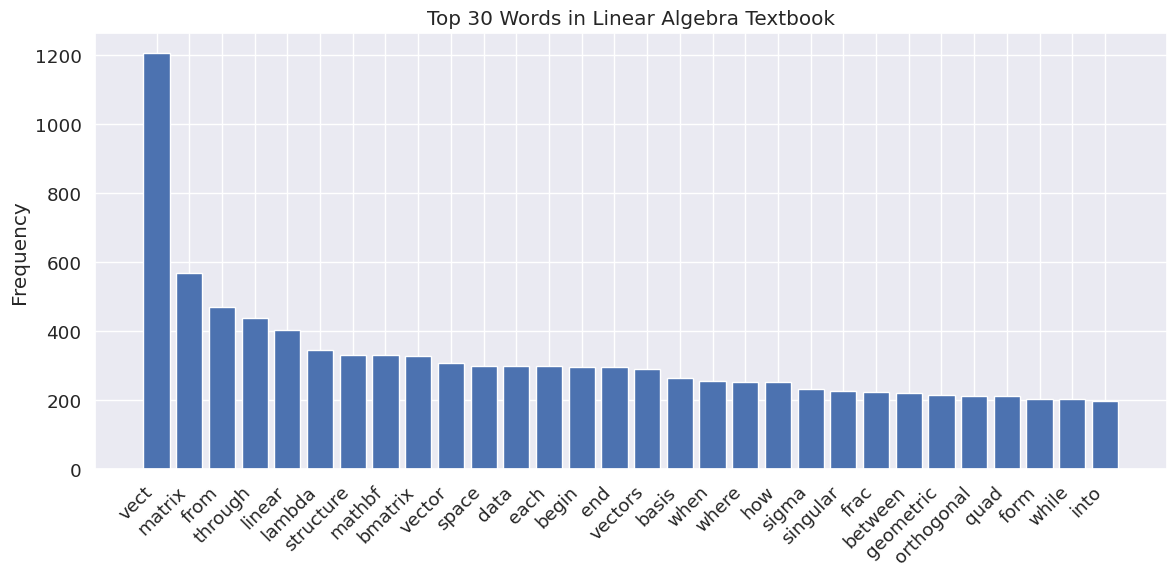


Computing BM25-like weighting (term frequency with diminishing returns)...

Top 30 terms by BM25-like weighting (frequency with diminishing returns):
vect: 2.27
matrix: 2.27
from: 2.27
through: 2.27
linear: 2.27
lambda: 2.27
structure: 2.27
mathbf: 2.27
bmatrix: 2.27
vector: 2.27
space: 2.27
data: 2.27
each: 2.27
begin: 2.27
end: 2.27
vectors: 2.27
basis: 2.27
when: 2.27
where: 2.27
how: 2.27
sigma: 2.27
singular: 2.27
frac: 2.27
between: 2.27
geometric: 2.27
orthogonal: 2.27
quad: 2.27
form: 2.27
while: 2.27
into: 2.27


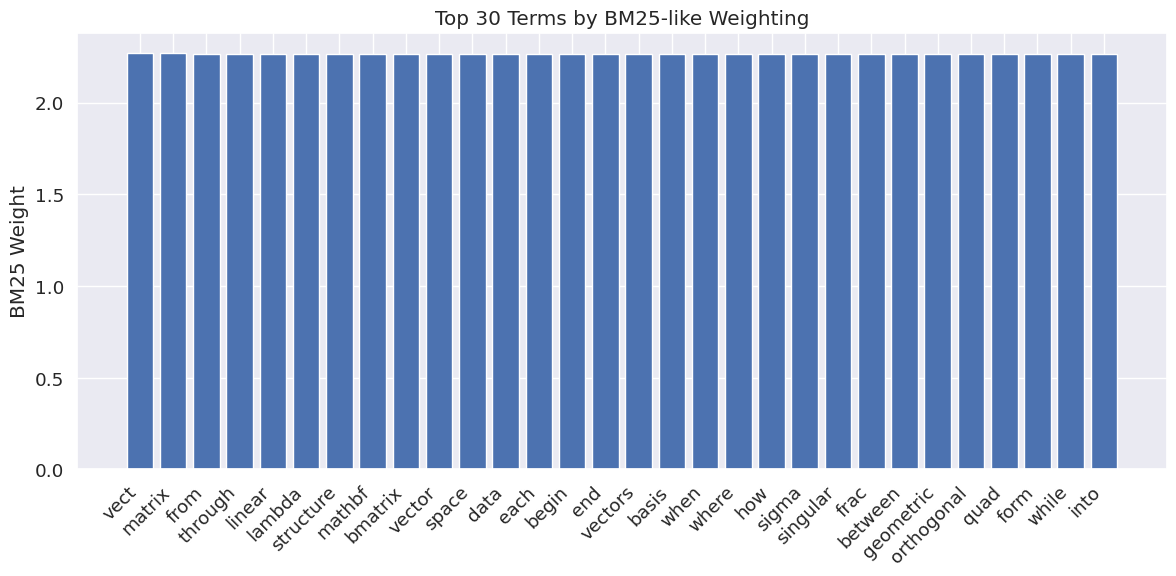


Analysis complete! Word frequency matrices have been computed and saved.
You can use these matrices for further analysis, such as:
1. Topic modeling
2. Term co-occurrence analysis
3. Identifying key concepts in the textbook
4. Comparing with other linear algebra textbooks


In [3]:
# Linear Algebra Textbook Word Frequency Analysis (No NLTK Dependencies)
# This notebook analyzes word frequencies in a linear algebra textbook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from google.colab import drive
import string
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Set plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)

# -------------------------------------------------------------------------
# PART 1: MOUNT GOOGLE DRIVE AND LOAD TEXTBOOK
# -------------------------------------------------------------------------

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

# Define the path to your textbook
# You may need to adjust this path to match your Drive folder structure
file_path = '/content/drive/My Drive/linear_textbook.txt'

# Load the textbook with error handling for different encodings
try:
    with open(file_path, 'r', encoding='utf-8') as file:
        textbook_content = file.read()
    print(f"Successfully loaded textbook: {len(textbook_content)} characters")
except UnicodeDecodeError:
    try:
        # Try with different encoding if utf-8 fails
        with open(file_path, 'r', encoding='latin-1') as file:
            textbook_content = file.read()
        print(f"Successfully loaded textbook with latin-1 encoding: {len(textbook_content)} characters")
    except:
        print("Failed to load the textbook with multiple encodings")
        raise
except FileNotFoundError:
    print(f"File not found: {file_path}")
    print("Please make sure the file exists in your Google Drive and the path is correct.")
    print("Remember to upload 'linear_textbook.txt' to your Google Drive before running this notebook!")
    raise

# Show a preview of the first 500 characters
print("\nPreview of textbook content:")
print("-" * 50)
print(textbook_content[:500] + "...")
print("-" * 50)

# -------------------------------------------------------------------------
# PART 2: PROCESS TEXTBOOK
# -------------------------------------------------------------------------

# Process the entire textbook as a single document for word frequency analysis
# Also create chunks for visualization purposes

def split_into_chunks(text, chunk_size=5000, overlap=0):
    """Split the textbook into equal-sized chunks for better visualization"""
    chunks = []
    chunk_titles = []

    # Get the total length of the text
    text_length = len(text)

    # Create chunks
    start = 0
    chunk_number = 1

    while start < text_length:
        # Calculate end position with consideration for text length
        end = min(start + chunk_size, text_length)

        # Extract chunk
        chunk = text[start:end]

        # Add to list
        chunks.append(chunk)
        chunk_titles.append(f"Chunk {chunk_number}")

        # Move start position for next chunk
        start = end - overlap if end < text_length else text_length
        chunk_number += 1

    return pd.DataFrame({'title': chunk_titles, 'text': chunks})

# Split textbook into chunks for easier analysis
print("\nProcessing textbook in manageable chunks...")
df = split_into_chunks(textbook_content)
print(f"Created {len(df)} chunks from the textbook.")

# -------------------------------------------------------------------------
# PART 3: TEXT PREPROCESSING
# -------------------------------------------------------------------------

# Define custom stopwords for linear algebra
math_stopwords = {
    'theorem', 'definition', 'example', 'proof', 'lemma', 'figure',
    'equation', 'thus', 'hence', 'let', 'since', 'therefore',
    'page', 'section', 'chapter', 'problem', 'solution', 'exercise',
    'show', 'find', 'given', 'solve', 'consider', 'suppose', 'assume'
}

# Basic stopwords
basic_stopwords = {
    'a', 'an', 'the', 'and', 'or', 'but', 'if', 'then',
    'is', 'are', 'was', 'were', 'be', 'been', 'being',
    'in', 'on', 'at', 'to', 'for', 'with', 'by', 'about',
    'of', 'this', 'that', 'these', 'those', 'it', 'its',
    'we', 'our', 'us', 'they', 'their', 'them', 'he', 'his',
    'him', 'she', 'her', 'hers', 'you', 'your', 'yours',
    'as', 'can', 'will', 'do', 'does', 'did', 'has', 'have',
    'had', 'may', 'might', 'must', 'should', 'would', 'could'
}

def custom_tokenize(text):
    """
    Custom tokenization without relying on NLTK
    This simple function splits on whitespace and removes punctuation
    """
    # Replace punctuation with spaces
    for char in string.punctuation:
        text = text.replace(char, ' ')

    # Normalize whitespace and split
    return text.split()

def preprocess_text(text, remove_stopwords=True):
    """
    Preprocess text without using NLTK
    """
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)

    # Simple tokenization
    tokens = custom_tokenize(text)

    # Remove stopwords
    if remove_stopwords:
        all_stopwords = basic_stopwords.union(math_stopwords)
        tokens = [token for token in tokens if token not in all_stopwords]

    # Remove short tokens
    tokens = [token for token in tokens if len(token) >= 3]

    return ' '.join(tokens)

# Apply preprocessing to each chunk
print("\nPreprocessing text...")
df['processed_text'] = df['text'].apply(preprocess_text)

# Process the entire textbook as one unit for term frequency analysis
full_processed_text = preprocess_text(textbook_content)
print(f"Full processed text length: {len(full_processed_text)} characters")

# Show a sample of processed text
print("\nSample of processed text (first chunk):")
print("-" * 50)
print(df.iloc[0]['processed_text'][:300] + "...")
print("-" * 50)

# -------------------------------------------------------------------------
# PART 4: COMPUTE WORD FREQUENCY MATRIX
# -------------------------------------------------------------------------

# We'll implement both TF-IDF and Count Vectorization

# TF-IDF Vectorization (Term Frequency-Inverse Document Frequency)
print("\nComputing TF-IDF matrix...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    min_df=2,          # Minimum document frequency
    max_df=0.9,        # Maximum document frequency (ignore words in >90% of docs)
    sublinear_tf=True  # Apply sublinear TF scaling
)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Convert to DataFrame for easier viewing
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    index=df['title'],
    columns=tfidf_feature_names
)

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Number of unique terms: {len(tfidf_feature_names)}")

# Sample of the TF-IDF matrix (first 5 terms for first 3 chunks)
sample_rows = min(3, tfidf_df.shape[0])
sample_cols = min(5, tfidf_df.shape[1])
print("\nSample of TF-IDF matrix (first few terms):")
print(tfidf_df.iloc[:sample_rows, :sample_cols])

# Count Vectorization (simple word count)
print("\nComputing Count matrix...")
count_vectorizer = CountVectorizer(
    max_features=1000,
    min_df=2,
    max_df=0.9
)
count_matrix = count_vectorizer.fit_transform(df['processed_text'])
count_feature_names = count_vectorizer.get_feature_names_out()

# Convert to DataFrame for easier viewing
count_df = pd.DataFrame(
    count_matrix.toarray(),
    index=df['title'],
    columns=count_feature_names
)

print(f"Count matrix shape: {count_matrix.shape}")

# Sample of the Count matrix (first 5 terms for first 3 chunks)
sample_rows = min(3, count_df.shape[0])
sample_cols = min(5, count_df.shape[1])
print("\nSample of Count matrix (first few terms):")
print(count_df.iloc[:sample_rows, :sample_cols])

# -------------------------------------------------------------------------
# PART 5: ANALYSIS AND VISUALIZATION
# -------------------------------------------------------------------------

# 1. Find the most frequent terms across the entire textbook
def get_top_terms(matrix, feature_names, top_n=20):
    """Get the top n most frequent terms"""
    # Sum frequencies across all documents
    term_sums = np.asarray(matrix.sum(axis=0)).flatten()
    # Sort term indices by frequency
    term_indices = term_sums.argsort()[-top_n:][::-1]
    # Get the terms and their frequencies
    top_terms = [(feature_names[i], term_sums[i]) for i in term_indices]
    return top_terms

# Get top terms from TF-IDF and Count matrices
tfidf_top_terms = get_top_terms(tfidf_matrix, tfidf_feature_names)
count_top_terms = get_top_terms(count_matrix, count_feature_names)

# Print top terms
print("\nTop 20 terms by TF-IDF weight:")
for term, weight in tfidf_top_terms:
    print(f"{term}: {weight:.2f}")

print("\nTop 20 terms by raw count:")
for term, count in count_top_terms:
    print(f"{term}: {int(count)}")

# 2. Visualize top terms
plt.figure(figsize=(12, 8))

# TF-IDF top terms
terms, weights = zip(*tfidf_top_terms)
plt.subplot(2, 1, 1)
plt.barh(range(len(terms)), weights, align='center')
plt.yticks(range(len(terms)), terms)
plt.gca().invert_yaxis()  # Highest values at the top
plt.title('Top 20 Terms by TF-IDF Weight')
plt.xlabel('TF-IDF Weight')

# Count top terms
terms, counts = zip(*count_top_terms)
plt.subplot(2, 1, 2)
plt.barh(range(len(terms)), counts, align='center')
plt.yticks(range(len(terms)), terms)
plt.gca().invert_yaxis()  # Highest values at the top
plt.title('Top 20 Terms by Raw Count')
plt.xlabel('Count')

plt.tight_layout()
plt.savefig('linear_algebra_top_terms.png')
display(plt.gcf())  # Display the figure in the notebook
plt.close()

# 3. Create a term-document heatmap for top terms
def plot_term_heatmap(matrix, feature_names, document_names, top_n=20):
    """Create a heatmap for the top n terms across documents"""
    # Get the top terms by overall frequency
    top_term_indices = np.asarray(matrix.sum(axis=0)).flatten().argsort()[-top_n:][::-1]
    top_terms = [feature_names[i] for i in top_term_indices]

    # Extract the sub-matrix for these terms (terms × documents)
    sub_matrix = matrix[:, top_term_indices].toarray().T

    # Handle the case where there are too many documents
    if len(document_names) > 20:
        # Subsample to 20 evenly distributed documents
        sample_indices = np.linspace(0, len(document_names)-1, 20, dtype=int)
        sub_matrix = sub_matrix[:, sample_indices]
        document_names = [document_names[i] for i in sample_indices]

    # Create a DataFrame for the heatmap
    heatmap_df = pd.DataFrame(
        sub_matrix,
        index=top_terms,
        columns=document_names
    )

    # Plot the heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(heatmap_df, cmap="YlGnBu", annot=False, linewidths=.5)
    plt.title(f'Top {top_n} Terms Across Textbook Chunks')
    plt.ylabel('Terms')
    plt.xlabel('Textbook Chunks')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('linear_algebra_term_heatmap.png')
    display(plt.gcf())  # Display the figure in the notebook
    plt.close()

# Plot heatmap for TF-IDF (if not too many chunks)
plot_term_heatmap(tfidf_matrix, tfidf_feature_names, df['title'].tolist())

# 4. Save the word frequency matrices for further analysis
tfidf_df.to_csv('linear_algebra_tfidf_matrix.csv')
count_df.to_csv('linear_algebra_count_matrix.csv')

# 5. Direct word frequency count for the entire textbook
print("\nComputing word frequencies for the entire textbook...")

# Simple tokenization without NLTK
words = custom_tokenize(full_processed_text)
word_counts = Counter(words)
print(f"Total unique words after preprocessing: {len(word_counts)}")

# Get the top words
top_words = word_counts.most_common(30)
print("\nTop 30 words in the entire textbook:")
for word, count in top_words:
    print(f"{word}: {count}")

# Visualize top words
plt.figure(figsize=(12, 6))
words, counts = zip(*top_words)
plt.bar(words, counts)
plt.xticks(rotation=45, ha='right')
plt.title('Top 30 Words in Linear Algebra Textbook')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('linear_algebra_top_words.png')
display(plt.gcf())  # Display the figure in the notebook
plt.close()

# 6. Advanced Analysis: Word Weighting with BM25
print("\nComputing BM25-like weighting (term frequency with diminishing returns)...")

# Simple BM25-like weighting calculation
def compute_bm25_weights(term_counts, k1=1.5, b=0.75):
    """
    Compute BM25-like weights for terms:
    - term_counts: dictionary of term frequencies
    - k1: term saturation parameter
    - b: document length normalization
    """
    # Get average term frequency
    avg_freq = sum(term_counts.values()) / len(term_counts) if term_counts else 0

    # Compute weights with diminishing returns for frequency
    weights = {}
    for term, freq in term_counts.items():
        # BM25-inspired weight formula (simplified)
        weight = (freq * (k1 + 1)) / (freq + k1 * (1 - b + b * (freq / avg_freq)))
        weights[term] = weight

    return weights

# Compute BM25-like weights for the entire document
bm25_weights = compute_bm25_weights(word_counts)

# Get top terms by BM25 weight
top_bm25_terms = sorted(bm25_weights.items(), key=lambda x: x[1], reverse=True)[:30]

print("\nTop 30 terms by BM25-like weighting (frequency with diminishing returns):")
for term, weight in top_bm25_terms:
    print(f"{term}: {weight:.2f}")

# Visualize top BM25 terms
plt.figure(figsize=(12, 6))
terms, weights = zip(*top_bm25_terms)
plt.bar(terms, weights)
plt.xticks(rotation=45, ha='right')
plt.title('Top 30 Terms by BM25-like Weighting')
plt.ylabel('BM25 Weight')
plt.tight_layout()
plt.savefig('linear_algebra_bm25_terms.png')
display(plt.gcf())  # Display the figure in the notebook
plt.close()

# Display a success message
print("\nAnalysis complete! Word frequency matrices have been computed and saved.")
print("You can use these matrices for further analysis, such as:")
print("1. Topic modeling")
print("2. Term co-occurrence analysis")
print("3. Identifying key concepts in the textbook")
print("4. Comparing with other linear algebra textbooks")


Performing Singular Value Decomposition (SVD) on the TF-IDF matrix...
Dimensions reduced from 1000 to 10
Explained variance by 10 components: 26.99%


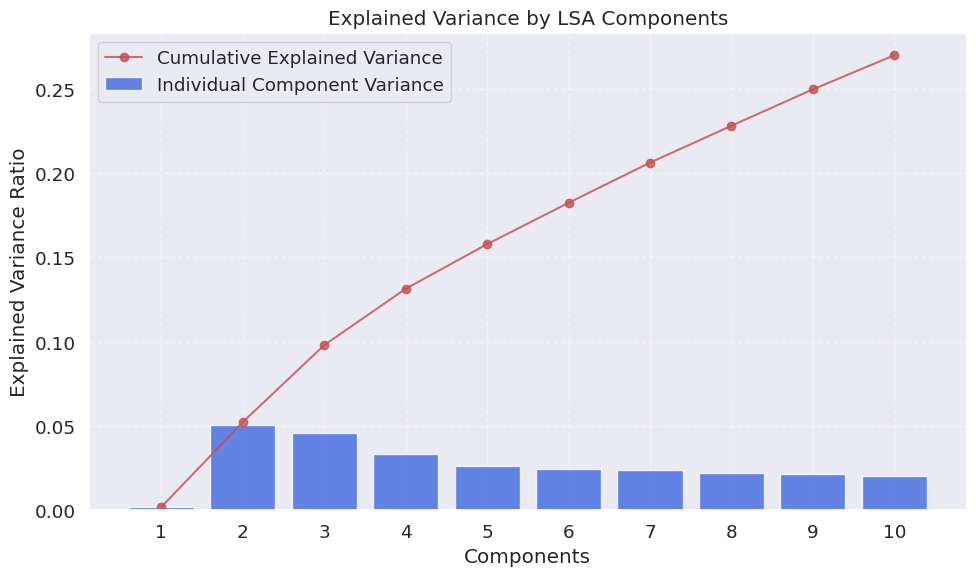


Top terms for each latent topic:

Topic 1:
  vect: 0.1493
  matrix: 0.1081
  linear: 0.0963
  bmatrix: 0.0944
  data: 0.0878
  vectors: 0.0876
  end: 0.0874
  lambda: 0.0868
  begin: 0.0866
  space: 0.0854

Topic 2:
  lambda: 0.2259
  pmatrix: 0.1960
  eigenvalues: 0.1688
  bmatrix: 0.1650
  eigenvalue: 0.1446
  end: 0.1408
  jordan: 0.1284
  begin: 0.1277
  eigenvectors: 0.1226
  exponential: 0.1222

Topic 3:
  inner: 0.1306
  spaces: 0.1225
  product: 0.1208
  orthogonal: 0.1150
  perp: 0.1100
  dim: 0.1064
  space: 0.1025
  subspaces: 0.1023
  vector: 0.1013
  basis: 0.0967

Topic 4:
  vect: 0.1493
  principal: 0.1361
  variation: 0.1354
  pca: 0.1086
  orthogonal: 0.1074
  sigma: 0.1065
  components: 0.0990
  variance: 0.0940
  direction: 0.0925
  cov: 0.0911

Topic 5:
  coordinates: 0.1663
  coordinate: 0.1556
  different: 0.1148
  bases: 0.0918
  representations: 0.0877
  sigma: 0.0871
  theta: 0.0858
  same: 0.0818
  change: 0.0741
  rotation: 0.0725

Topic 6:
  basis: 0.1648
 

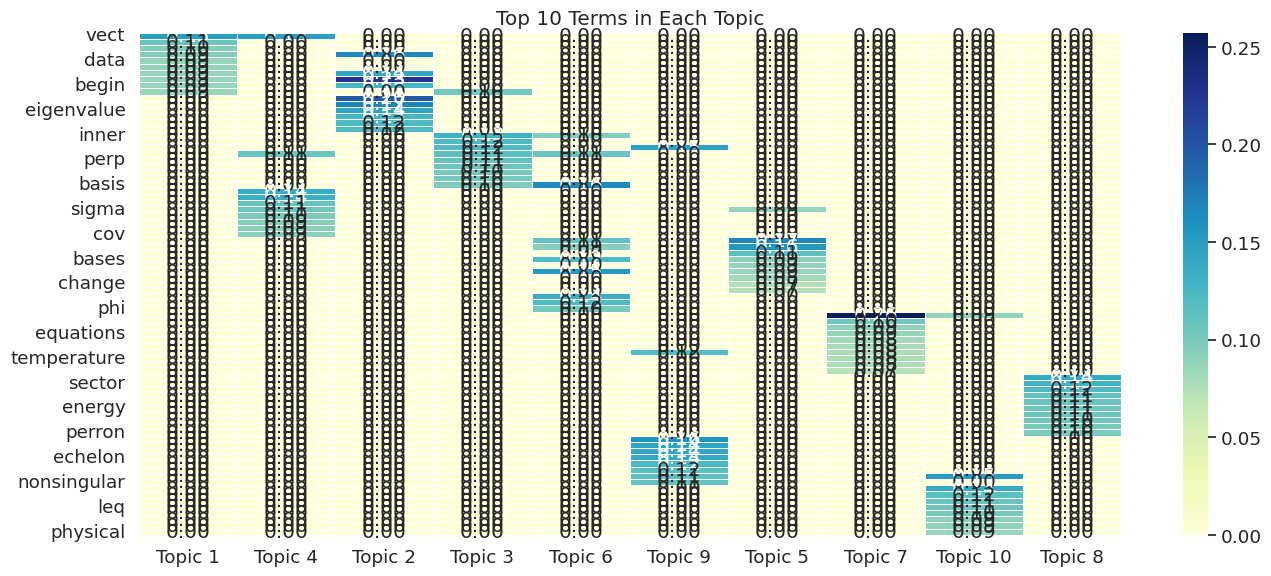


Dominant topic for each document chunk:
Chunk 1: Topic 1.0
Chunk 2: Topic 1.0
Chunk 3: Topic 9.0
Chunk 4: Topic 1.0
Chunk 5: Topic 9.0
Chunk 6: Topic 9.0
Chunk 7: Topic 1.0
Chunk 8: Topic 1.0
Chunk 9: Topic 1.0
Chunk 10: Topic 1.0
Chunk 11: Topic 1.0
Chunk 12: Topic 1.0
Chunk 13: Topic 1.0
Chunk 14: Topic 1.0
Chunk 15: Topic 1.0
Chunk 16: Topic 1.0
Chunk 17: Topic 1.0
Chunk 18: Topic 1.0
Chunk 19: Topic 1.0
Chunk 20: Topic 1.0
Chunk 21: Topic 1.0
Chunk 22: Topic 1.0
Chunk 23: Topic 1.0
Chunk 24: Topic 1.0
Chunk 25: Topic 1.0
Chunk 26: Topic 1.0
Chunk 27: Topic 1.0
Chunk 28: Topic 1.0
Chunk 29: Topic 1.0
Chunk 30: Topic 1.0
Chunk 31: Topic 1.0
Chunk 32: Topic 1.0
Chunk 33: Topic 1.0
Chunk 34: Topic 1.0
Chunk 35: Topic 1.0
Chunk 36: Topic 1.0
Chunk 37: Topic 1.0
Chunk 38: Topic 1.0
Chunk 39: Topic 1.0
Chunk 40: Topic 1.0
Chunk 41: Topic 1.0
Chunk 42: Topic 1.0
Chunk 43: Topic 1.0
Chunk 44: Topic 1.0
Chunk 45: Topic 1.0
Chunk 46: Topic 1.0
Chunk 47: Topic 1.0
Chunk 48: Topic 1.0
Chunk 49

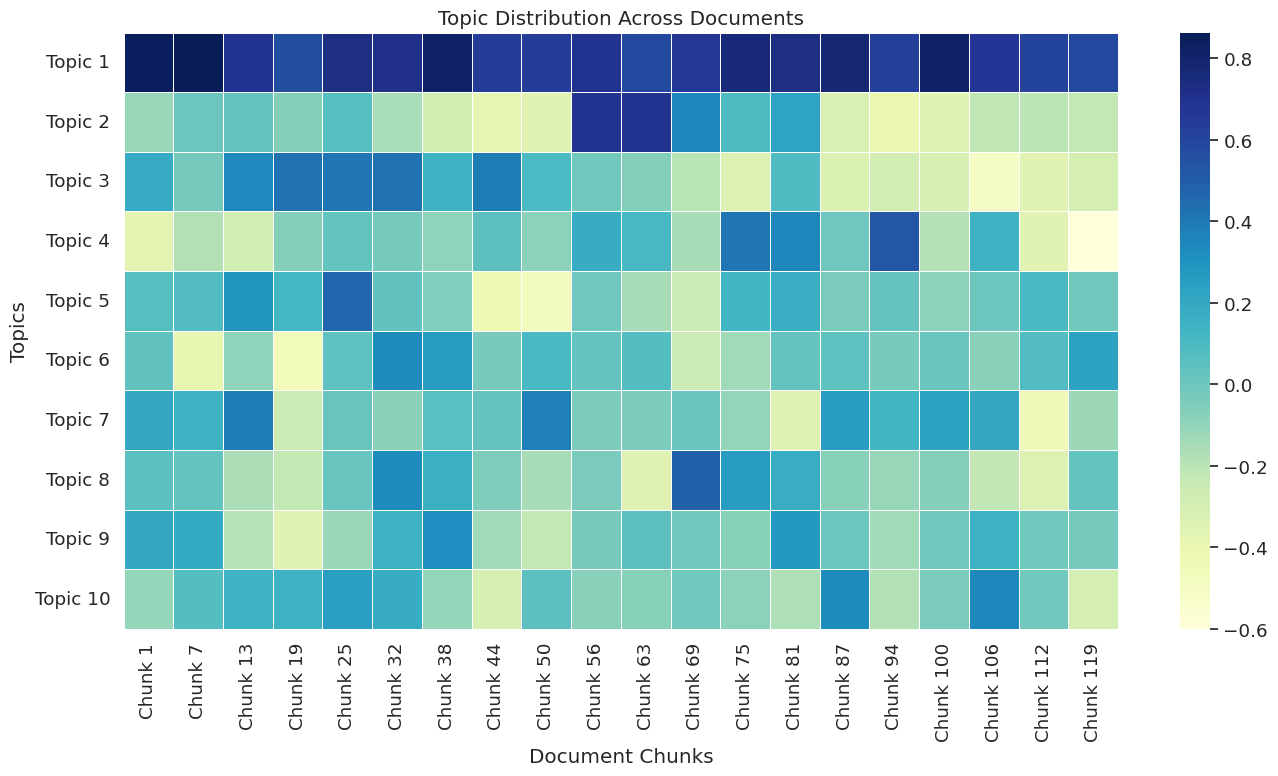

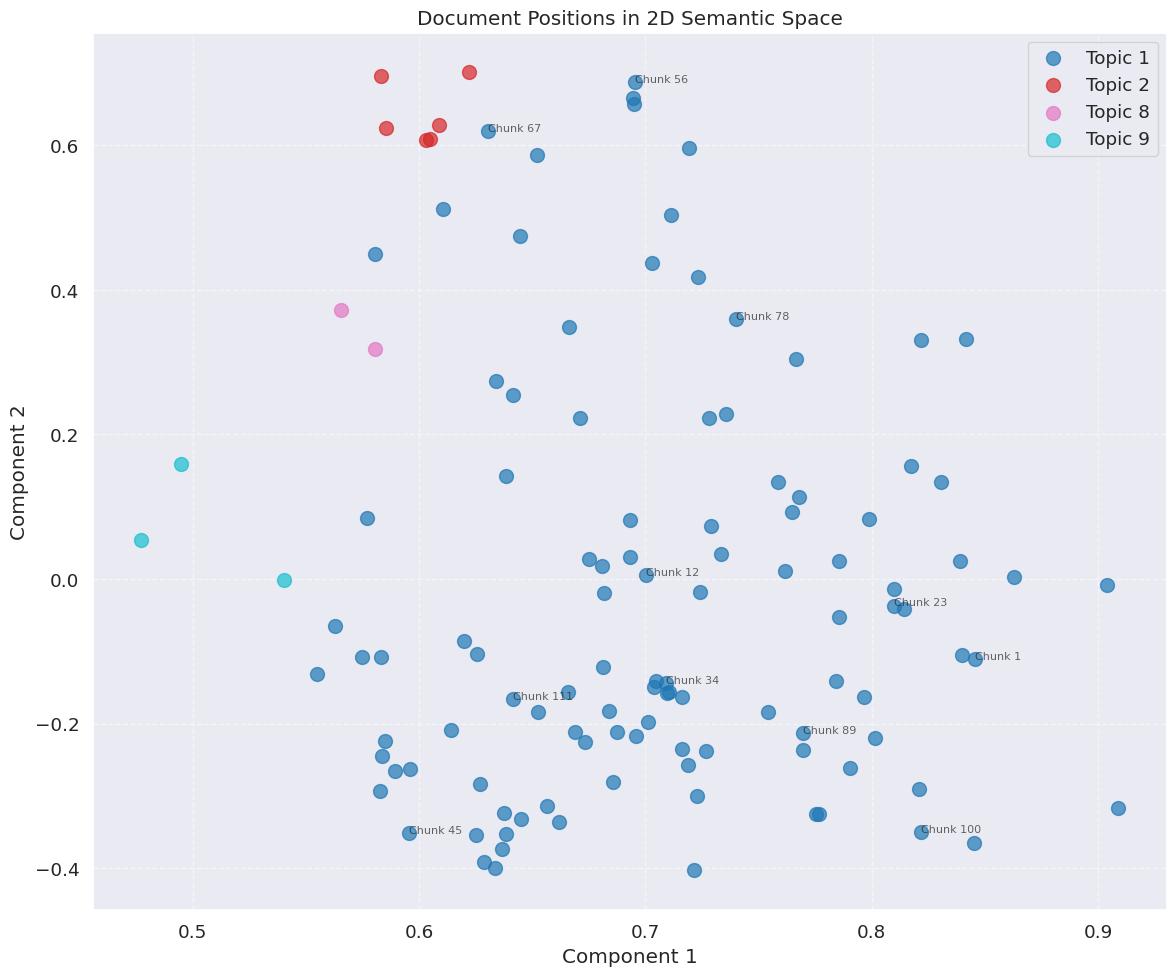

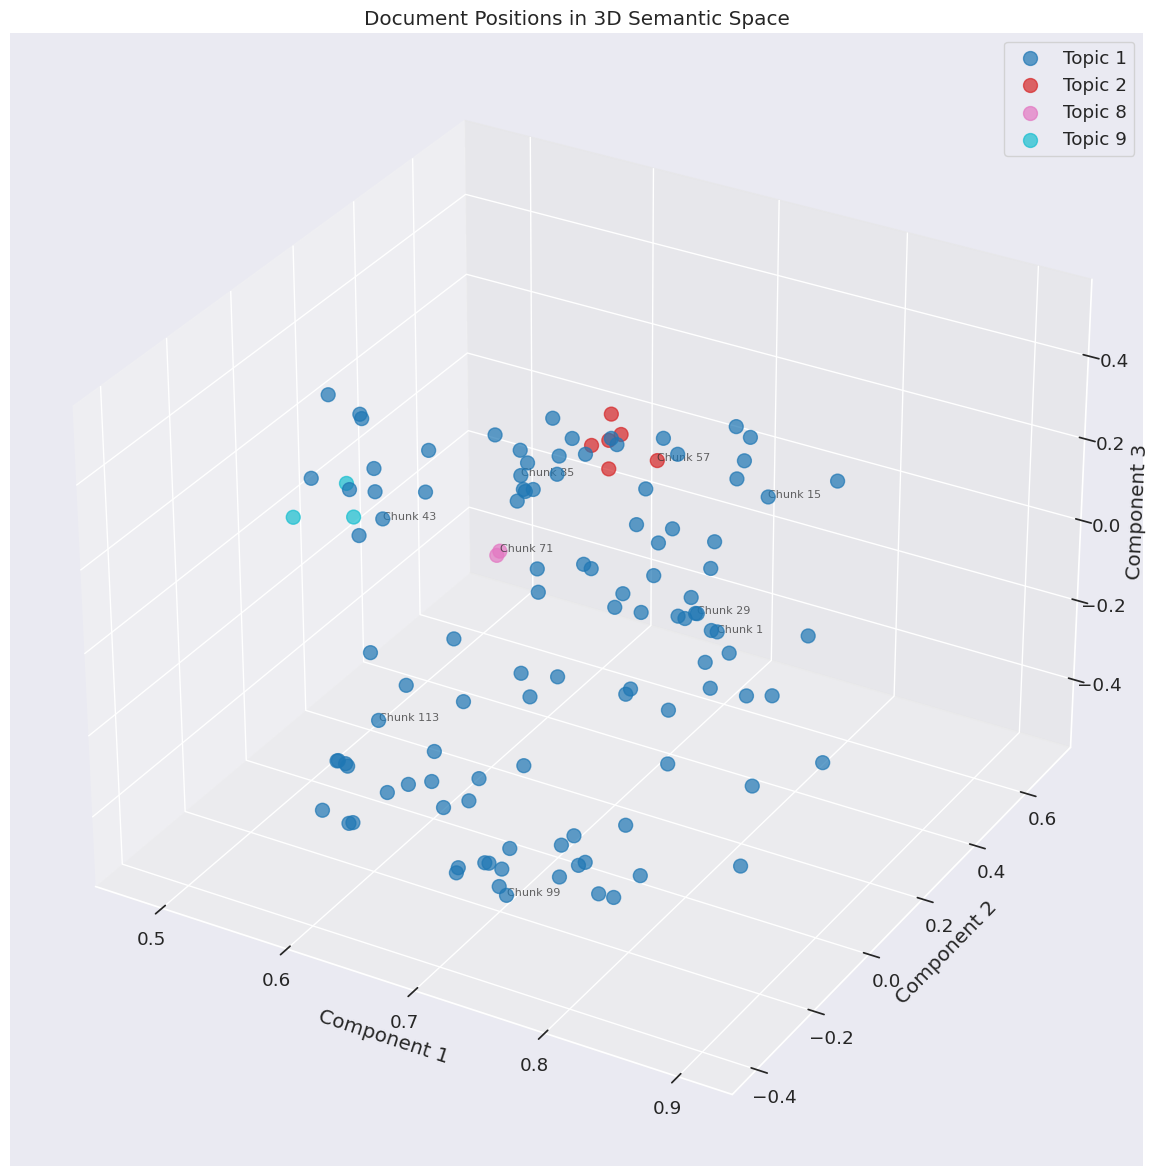

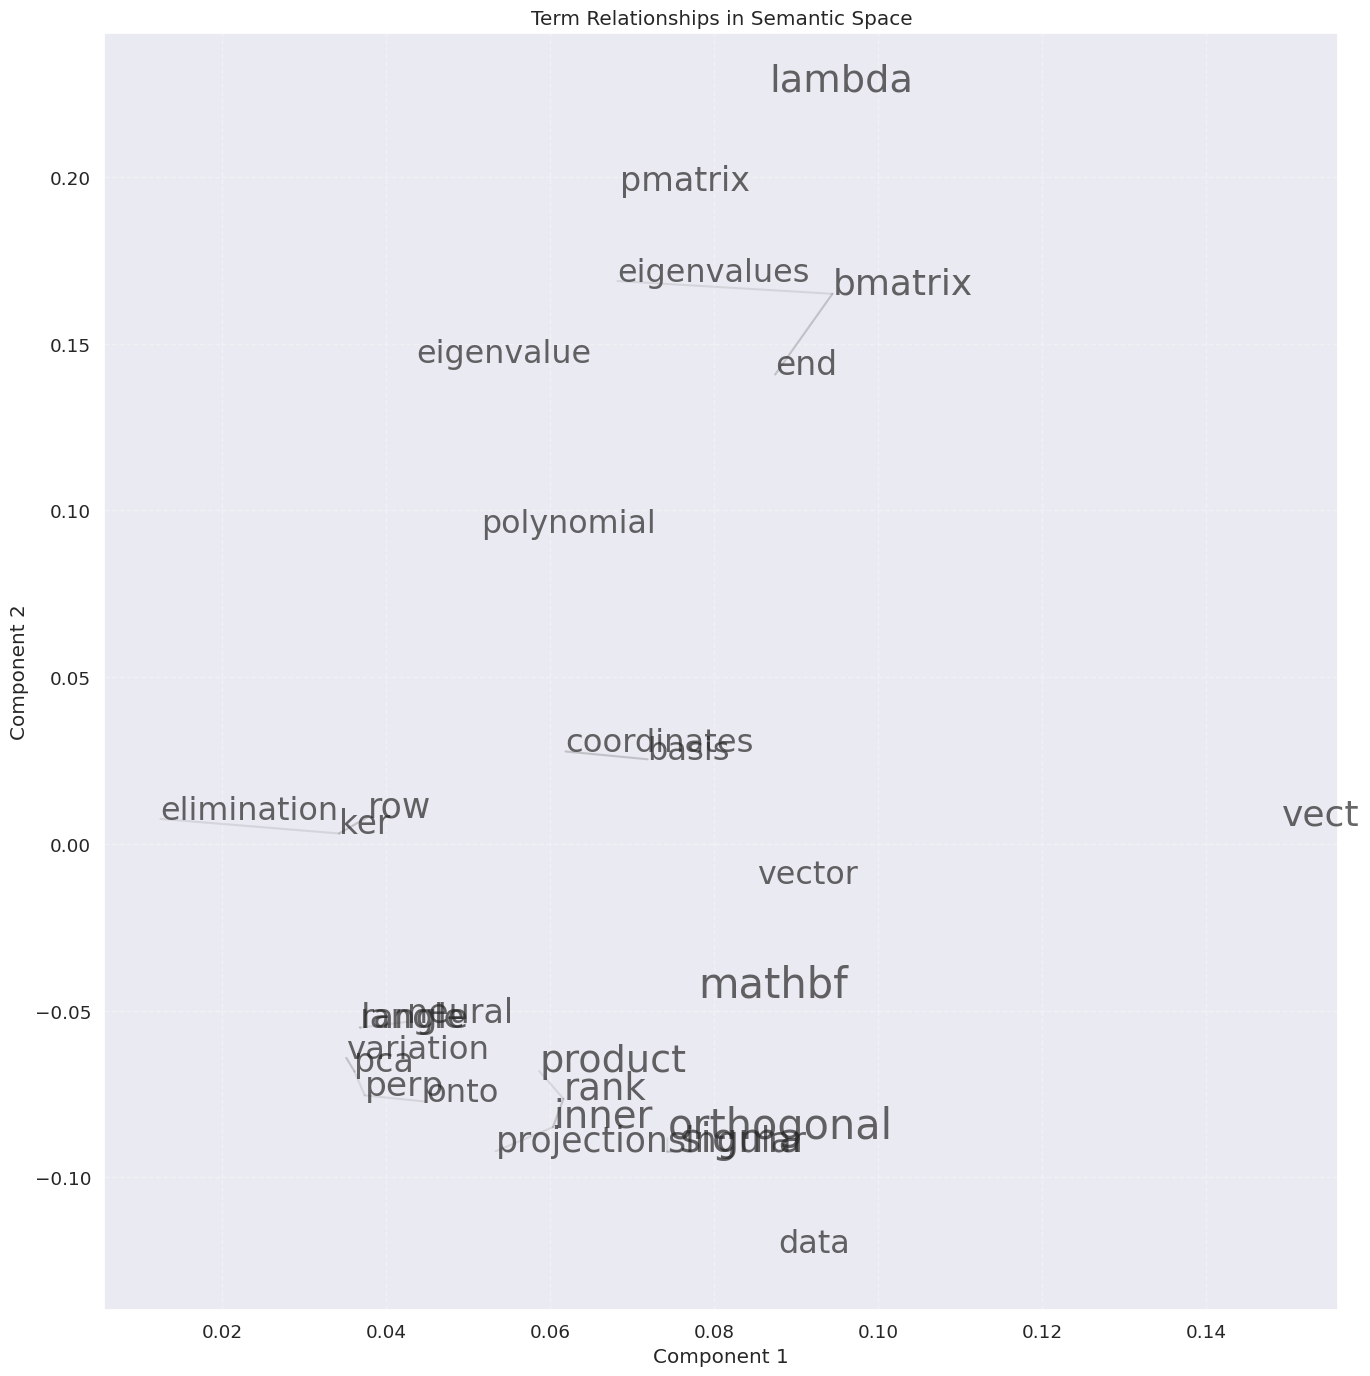


Semanticallv similar terms based on LSA:

Terms similar to 'matrix':
  matrices: 0.8547
  requires: 0.8222
  more: 0.8151
  which: 0.8060
  square: 0.7870
  reveals: 0.7838
  appears: 0.7795
  factor: 0.7737
  entries: 0.7606
  maps: 0.7527

Terms similar to 'vector':
  spaces: 0.9207
  space: 0.9175
  examples: 0.8906
  whether: 0.8843
  familiar: 0.8737
  combinations: 0.8596
  collection: 0.8594
  spans: 0.8570
  origin: 0.8466
  notion: 0.8418

Terms similar to 'eigenvalue':
  determines: 0.9771
  eigenvector: 0.9571
  growth: 0.9178
  repeated: 0.9093
  powers: 0.9061
  initial: 0.8993
  behavior: 0.8954
  eigenvalues: 0.8881
  evolution: 0.8607
  influence: 0.8557

Terms similar to 'linear':
  there: 0.9472
  not: 0.9143
  all: 0.8673
  algebra: 0.8549
  plane: 0.8389
  which: 0.8344
  understanding: 0.8334
  deeper: 0.8131
  what: 0.8039
  multiplication: 0.7959

Terms similar to 'space':
  spaces: 0.9629
  vector: 0.9175
  origin: 0.9077
  whether: 0.8825
  combinations: 0.878

In [5]:
# Latent Semantic Analysis (LSA) on Linear Algebra Textbook
# This extends the previous analysis by performing SVD and LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from collections import defaultdict
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

# Set plot style for consistency
plt.style.use('ggplot')
sns.set(font_scale=1.2)

# -------------------------------------------------------------------------
# PART 1: COMPUTE SVD ON THE TERM-DOCUMENT MATRIX
# -------------------------------------------------------------------------

print("\nPerforming Singular Value Decomposition (SVD) on the TF-IDF matrix...")

# Number of topics (dimensions) to extract
n_components = 10  # You can adjust this based on your needs

# Create the SVD model
svd = TruncatedSVD(n_components=n_components, random_state=42)

# Fit the model and transform the TF-IDF matrix
lsa_result = svd.fit_transform(tfidf_matrix)

# Normalize the LSA result (optional but recommended)
normalizer = Normalizer(copy=False)
lsa_norm = normalizer.fit_transform(lsa_result)

# Get the components (term-topic matrix)
components = svd.components_

# Get explained variance ratio
explained_variance = svd.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"Dimensions reduced from {tfidf_matrix.shape[1]} to {n_components}")
print(f"Explained variance by {n_components} components: {sum(explained_variance):.2%}")

# -------------------------------------------------------------------------
# PART 2: VISUALIZE THE EXPLAINED VARIANCE
# -------------------------------------------------------------------------

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, n_components + 1), explained_variance, alpha=0.8, color='royalblue')
plt.plot(range(1, n_components + 1), cumulative_variance, 'r-o', alpha=0.8)
plt.xlabel('Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by LSA Components')
plt.xticks(range(1, n_components + 1))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(['Cumulative Explained Variance', 'Individual Component Variance'])
plt.tight_layout()
plt.savefig('lsa_explained_variance.png')
display(plt.gcf())
plt.close()

# -------------------------------------------------------------------------
# PART 3: EXTRACT AND VISUALIZE TOPICS
# -------------------------------------------------------------------------

# Function to get the top terms for each topic/component
def get_top_terms_per_topic(components, feature_names, n_top_terms=10):
    top_terms = []
    for i, component in enumerate(components):
        # Sort terms by their coefficient in this component
        terms_idx = component.argsort()[:-n_top_terms-1:-1]
        top_component_terms = [(feature_names[idx], component[idx]) for idx in terms_idx]
        top_terms.append(top_component_terms)
    return top_terms

# Get top terms for each topic
top_terms_per_topic = get_top_terms_per_topic(components, tfidf_feature_names)

# Print the topics and their top terms
print("\nTop terms for each latent topic:")
for i, terms in enumerate(top_terms_per_topic):
    print(f"\nTopic {i+1}:")
    for term, weight in terms:
        print(f"  {term}: {weight:.4f}")

# Visualize the top terms in each topic as a heatmap
def plot_term_topic_heatmap(components, feature_names, n_top_terms=10):
    # Get top terms for each topic
    top_terms = []
    top_term_weights = []

    for topic_idx, topic in enumerate(components):
        # Sort terms by weight in this topic
        sorted_terms_idx = topic.argsort()[:-n_top_terms-1:-1]
        top_terms.append([feature_names[i] for i in sorted_terms_idx])
        top_term_weights.append([topic[i] for i in sorted_terms_idx])

    # Create a DataFrame for the heatmap
    topic_names = [f"Topic {i+1}" for i in range(len(components))]

    # Create a dictionary to store term weights by topic
    term_weight_dict = defaultdict(dict)

    for topic_idx, terms in enumerate(top_terms):
        for term_idx, term in enumerate(terms):
            term_weight_dict[term][topic_names[topic_idx]] = top_term_weights[topic_idx][term_idx]

    # Convert to DataFrame
    df = pd.DataFrame(term_weight_dict).T.fillna(0)

    # Plot
    plt.figure(figsize=(14, n_top_terms * 0.6))
    sns.heatmap(df, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5)
    plt.title(f'Top {n_top_terms} Terms in Each Topic')
    plt.tight_layout()
    plt.savefig('lsa_topic_term_heatmap.png')
    display(plt.gcf())
    plt.close()

# Plot the term-topic heatmap
plot_term_topic_heatmap(components, tfidf_feature_names)

# -------------------------------------------------------------------------
# PART 4: DOCUMENT-TOPIC RELATIONSHIPS
# -------------------------------------------------------------------------

# Create a DataFrame for document-topic relationships
doc_topic_df = pd.DataFrame(lsa_norm,
                          index=df['title'],
                          columns=[f'Topic {i+1}' for i in range(n_components)])

# Print the dominant topic for each document
print("\nDominant topic for each document chunk:")
doc_topic_df['Dominant Topic'] = np.argmax(lsa_norm, axis=1) + 1
for idx, row in doc_topic_df.iterrows():
    print(f"{idx}: Topic {row['Dominant Topic']}")

# Visualize document-topic relationships
plt.figure(figsize=(14, 8))

# Limit to a reasonable number of documents for visualization
max_docs = 20
if len(doc_topic_df) > max_docs:
    # Sample documents evenly
    sample_indices = np.linspace(0, len(doc_topic_df)-1, max_docs, dtype=int)
    sample_df = doc_topic_df.iloc[sample_indices].drop('Dominant Topic', axis=1)
else:
    sample_df = doc_topic_df.drop('Dominant Topic', axis=1)

# Transpose for better visualization (topics as rows, documents as columns)
sns.heatmap(sample_df.T, annot=False, cmap="YlGnBu", linewidths=0.5)
plt.title('Topic Distribution Across Documents')
plt.xlabel('Document Chunks')
plt.ylabel('Topics')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('lsa_document_topic_heatmap.png')
display(plt.gcf())
plt.close()

# -------------------------------------------------------------------------
# PART 5: SEMANTIC SPACE VISUALIZATION
# -------------------------------------------------------------------------

# 2D visualization of documents in semantic space
plt.figure(figsize=(12, 10))

# Use the first two components for a 2D plot
x = lsa_norm[:, 0]
y = lsa_norm[:, 1]

# Color by dominant topic
dominant_topics = doc_topic_df['Dominant Topic'].values
unique_topics = np.unique(dominant_topics)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_topics)))

# Create a scatter plot
for topic, color in zip(unique_topics, colors):
    mask = dominant_topics == topic
    plt.scatter(x[mask], y[mask], c=[color], s=100, alpha=0.7, label=f'Topic {topic}')

# Label a few points (documents) for reference
if len(df) <= 20:
    # Label all documents if there are few
    for i, title in enumerate(df['title']):
        plt.annotate(title, (x[i], y[i]), fontsize=8, alpha=0.7)
else:
    # Label just a few documents
    for i in range(0, len(df), len(df)//10):
        plt.annotate(df['title'].iloc[i], (x[i], y[i]), fontsize=8, alpha=0.7)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Document Positions in 2D Semantic Space')
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('lsa_2d_semantic_space.png')
display(plt.gcf())
plt.close()

# 3D visualization if we have at least 3 components
if n_components >= 3:
    fig = plt.figure(figsize=(14, 12))
    ax = fig.add_subplot(111, projection='3d')

    x = lsa_norm[:, 0]
    y = lsa_norm[:, 1]
    z = lsa_norm[:, 2]

    # Color by dominant topic
    for topic, color in zip(unique_topics, colors):
        mask = dominant_topics == topic
        ax.scatter(x[mask], y[mask], z[mask], c=[color], s=100, alpha=0.7, label=f'Topic {topic}')

    # Label a few points
    if len(df) <= 15:
        for i, title in enumerate(df['title']):
            ax.text(x[i], y[i], z[i], title, fontsize=8, alpha=0.7)
    else:
        for i in range(0, len(df), len(df)//8):
            ax.text(x[i], y[i], z[i], df['title'].iloc[i], fontsize=8, alpha=0.7)

    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    ax.set_title('Document Positions in 3D Semantic Space')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('lsa_3d_semantic_space.png')
    display(plt.gcf())
    plt.close()

# -------------------------------------------------------------------------
# PART 6: TERM RELATIONSHIPS IN SEMANTIC SPACE
# -------------------------------------------------------------------------

# Visualize term relationships in the latent semantic space
def plot_term_relationships(components, feature_names, n_top_terms=30):
    # Get the top terms overall based on their weight across all components
    term_importance = np.sum(np.abs(components), axis=0)
    top_indices = term_importance.argsort()[-n_top_terms:][::-1]
    top_terms = [feature_names[i] for i in top_indices]

    # Get the coordinates of these terms in the semantic space (first 2 dimensions)
    term_coords = components.T[top_indices, :2]

    # Plot terms in 2D space
    plt.figure(figsize=(14, 14))
    plt.scatter(term_coords[:, 0], term_coords[:, 1], alpha=0)  # Invisible points, just for scale

    # Add term labels
    for i, term in enumerate(top_terms):
        x, y = term_coords[i, 0], term_coords[i, 1]
        # Scale term size by importance
        size = 10 + (20 * (term_importance[top_indices[i]] / term_importance[top_indices[0]]))
        plt.annotate(term, xy=(x, y), fontsize=size, alpha=0.7)

    # Draw lines between semantically related terms (optional)
    # We'll define "related" as terms that are close in this 2D space
    from scipy.spatial.distance import pdist, squareform
    distances = squareform(pdist(term_coords))

    # For each term, connect to its closest neighbor
    for i in range(len(top_terms)):
        # Find the closest term (excluding itself)
        distances_from_i = distances[i]
        distances_from_i[i] = np.inf  # Exclude self
        closest_j = np.argmin(distances_from_i)

        # Only draw lines if the terms are reasonably close
        if distances_from_i[closest_j] < np.percentile(distances, 15):  # Adjust threshold as needed
            plt.plot([term_coords[i, 0], term_coords[closest_j, 0]],
                     [term_coords[i, 1], term_coords[closest_j, 1]],
                     'k-', alpha=0.1)

    plt.title('Term Relationships in Semantic Space')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig('lsa_term_relationships.png')
    display(plt.gcf())
    plt.close()

# Plot term relationships
plot_term_relationships(components, tfidf_feature_names)

# -------------------------------------------------------------------------
# PART 7: SEMANTIC SIMILARITY BETWEEN TERMS
# -------------------------------------------------------------------------

# Calculate semantic similarity between terms in the LSA space
def calculate_term_similarities(components, feature_names, query_terms=None, top_n=10):
    """
    Find semantically similar terms based on LSA components
    """
    # If no query terms provided, use some of the most important terms
    if query_terms is None:
        term_importance = np.sum(np.abs(components), axis=0)
        top_indices = term_importance.argsort()[-5:][::-1]  # Use top 5 terms
        query_terms = [feature_names[i] for i in top_indices]

    # Get term vectors in LSA space
    term_vecs = components.T

    results = {}
    for query in query_terms:
        if query not in feature_names:
            print(f"Term '{query}' not found in vocabulary")
            continue

        # Get the query term's index and vector
        query_idx = np.where(feature_names == query)[0][0]
        query_vec = term_vecs[query_idx]

        # Calculate cosine similarity with all other terms
        similarities = np.dot(term_vecs, query_vec) / (
            np.linalg.norm(term_vecs, axis=1) * np.linalg.norm(query_vec)
        )

        # Get top similar terms (excluding the query term itself)
        similarities[query_idx] = -np.inf  # Exclude self
        top_similar_indices = similarities.argsort()[-top_n:][::-1]
        top_similar_terms = [(feature_names[i], similarities[i]) for i in top_similar_indices]

        results[query] = top_similar_terms

    return results

# Try to find some interesting math terms that might be in the vocabulary
potential_query_terms = ['matrix', 'vector', 'eigenvalue', 'linear', 'space', 'function']
valid_query_terms = [term for term in potential_query_terms if term in tfidf_feature_names]

if not valid_query_terms:
    # If none of our suggested terms are found, use the top terms by importance
    term_importance = np.sum(np.abs(components), axis=0)
    top_indices = term_importance.argsort()[-5:][::-1]
    valid_query_terms = [tfidf_feature_names[i] for i in top_indices]

# Calculate and display semantic similarities
term_similarities = calculate_term_similarities(components, tfidf_feature_names,
                                              query_terms=valid_query_terms)

print("\nSemanticallv similar terms based on LSA:")
for query, similar_terms in term_similarities.items():
    print(f"\nTerms similar to '{query}':")
    for term, similarity in similar_terms:
        print(f"  {term}: {similarity:.4f}")

# -------------------------------------------------------------------------
# PART 8: DOCUMENT SIMILARITY ANALYSIS
# -------------------------------------------------------------------------

# Function to find similar documents based on their position in LSA space
def find_similar_documents(lsa_norm, document_titles, query_idx, top_n=5):
    """
    Find documents similar to a query document based on LSA coordinates
    """
    # Get the query document's vector
    query_vec = lsa_norm[query_idx]

    # Calculate cosine similarity with all documents
    similarities = np.dot(lsa_norm, query_vec) / (
        np.linalg.norm(lsa_norm, axis=1) * np.linalg.norm(query_vec)
    )

    # Get top similar documents (excluding the query document itself)
    similarities[query_idx] = -np.inf  # Exclude self
    top_similar_indices = similarities.argsort()[-top_n:][::-1]
    top_similar_docs = [(document_titles[i], similarities[i]) for i in top_similar_indices]

    return top_similar_docs

# Pick some example query documents
query_indices = [0]  # Start with the first document
if len(df) > 10:
    # Add a document from the middle and end if corpus is large enough
    query_indices.extend([len(df) // 2, len(df) - 1])

print("\nDocument similarity analysis:")
for query_idx in query_indices:
    query_title = df['title'].iloc[query_idx]
    similar_docs = find_similar_documents(lsa_norm, df['title'].values, query_idx)

    print(f"\nDocuments similar to '{query_title}':")
    for doc, similarity in similar_docs:
        print(f"  {doc}: {similarity:.4f}")

# -------------------------------------------------------------------------
# PART 9: SUMMARY AND INTERPRETATION
# -------------------------------------------------------------------------

print("\n" + "="*80)
print("LATENT SEMANTIC ANALYSIS (LSA) SUMMARY")
print("="*80)

print(f"\n1. Dimensionality Reduction:")
print(f"   - Original dimensions: {tfidf_matrix.shape[1]} terms")
print(f"   - Reduced to: {n_components} latent semantic dimensions")
print(f"   - Total variance explained: {sum(explained_variance):.2%}")

print(f"\n2. Key Topics Discovered:")
for i, terms in enumerate(top_terms_per_topic[:5]):  # Show first 5 topics
    top_topic_terms = ', '.join([term for term, _ in terms[:5]])
    print(f"   - Topic {i+1}: {top_topic_terms}")

print(f"\n3. Document Distribution:")
topic_counts = doc_topic_df['Dominant Topic'].value_counts().sort_index()
for topic, count in topic_counts.items():
    print(f"   - Topic {topic}: {count} documents ({count/len(df):.1%})")

print(f"\n4. Semantic Relationships:")
print(f"   - Found semantic similarities between related terms")
print(f"   - Identified document clusters in semantic space")

print(f"\n5. How to Interpret LSA Results:")
print(f"   - Each latent dimension represents a 'concept' or 'theme'")
print(f"   - Terms with high weights in a dimension are semantically related")
print(f"   - Documents close in semantic space discuss similar concepts")
print(f"   - LSA captures synonymy and, to some extent, polysemy")

print("\nThis analysis helps reveal the underlying semantic structure of the textbook,")
print("showing how terms and concepts are related across the document.")

# Save the LSA model components for potential future use
np.save('lsa_components.npy', components)
np.save('lsa_document_coordinates.npy', lsa_norm)
pd.DataFrame(top_terms_per_topic).to_csv('lsa_topics.csv')